# **Presentation of Student Score Prediction**

The objective of this notebook is to predict an exam score using a dataset containing the following variables:
* id
* age
* gender
* course
* study_hours
* class_attendance
* internet_access
* sleep_hours
* sleep_quality
* study_method
* facility_rating
* exam_difficulty
* exam_score

The Root Mean Square Error (RMSE) is used to evaluate the model’s performance.

To achieve this objective, the work is organized into several phases:
* data quality assessment
* exploration of data dependencies
* model development
* analysis of the resulting model

**Input files:**
* train.csv : data used to train the current model
* test.csv : data used to evaluate the model (Kaggle competition)
* Exam_Score_Prediction.csv : original dataset used to build the current dataset of this competition

**Model description:**
Several models are tested in this Notebook:
* the best model uses XGBoost with specific columns, using the orginal data.
* the same version has been tested using CatBoost.
* at the end of this Notebook an hybrid model has been tested composed by a linear model plus a neural network to evaluate residuals.

At last, the Auto-Gluon algorithm was tested to find the best model.

In [1]:
# Optionnal Installation of Autogluon : an algo to define the best model (costly)
# !pip install autogluon.tabular[all] -U
# from autogluon.tabular import TabularPredictor

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import xgboost as xgb
from catboost import CatBoostRegressor
from catboost import Pool

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

import seaborn as sns
import matplotlib.pyplot as plt
import math

from tensorflow.keras import layers, models

# Input files management

train_df = None
test_df = None

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # data to train the model
        if filename == 'train.csv':
            train_df = pd.read_csv(os.path.join(dirname, filename))
        # data to compute the submission file
        elif filename == 'test.csv':
            test_df = pd.read_csv(os.path.join(dirname, filename))
        # data extracted from a previous close data set
        elif filename == 'Exam_Score_Prediction.csv':
            orig_df = pd.read_csv(os.path.join(dirname, filename)) 


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2026-02-03 08:40:01.574157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770108001.767662     968 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770108001.825579     968 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770108002.305535     968 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770108002.305578     968 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770108002.305581     968 computation_placer.cc:177] computation placer alr

# **Description of Data**
* id
* age
* gender
* course
* study_hours
* class_attendance
* internet_access
* sleep_hours
* sleep_quality
* study_method
* facility_rating
* exam_difficulty
* exam_score

In [3]:
print("size of the training data")
print(len(train_df.id))

size of the training data
630000


In [4]:
# Numerical columns
numeric_cols = train_df.select_dtypes(include=['int64','float64']).columns

# categorical columns
cat_cols = train_df.select_dtypes(include='object').columns

# **Check Data**

## global analysis of Numerical columns

In [5]:
# Analysis of numeric columns

num_analysis = []

for col in numeric_cols:
    num_analysis.append({
        'Variable': col,
        'NaN': train_df[col].isna().sum(),
        'Nb de Zéros': (train_df[col] == 0).sum(),
        'Valeurs Uniques': train_df[col].nunique(),
        'Min': train_df[col].min(),
        'Max': train_df[col].max(),
        'Moyenne': round(train_df[col].mean(), 2)
    })

df_num_check = pd.DataFrame(num_analysis)
print(df_num_check)

           Variable  NaN  Nb de Zéros  Valeurs Uniques     Min        Max  \
0                id    0            1           630000   0.000  629999.00   
1               age    0            0                8  17.000      24.00   
2       study_hours    0            0              792   0.080       7.91   
3  class_attendance    0            0              617  40.600      99.40   
4       sleep_hours    0            0               66   4.100       9.90   
5        exam_score    0            0              805  19.599     100.00   

     Moyenne  
0  314999.50  
1      20.55  
2       4.00  
3      71.99  
4       7.07  
5      62.51  


## Global analysis of Categorical columns

In [6]:
# Analysis of categorical columns
analysis = []

for col in cat_cols:
    analysis.append({
        'Variable': col,
        'NaN': train_df[col].isna().sum(),
        'Cases Vides': (train_df[col] == "").sum(),
        'Valeurs Uniques': train_df[col].nunique()
    })

df_check = pd.DataFrame(analysis)
print(df_check)

          Variable  NaN  Cases Vides  Valeurs Uniques
0           gender    0            0                3
1           course    0            0                7
2  internet_access    0            0                2
3    sleep_quality    0            0                3
4     study_method    0            0                5
5  facility_rating    0            0                3
6  exam_difficulty    0            0                3


## Detailed visualization of each variable

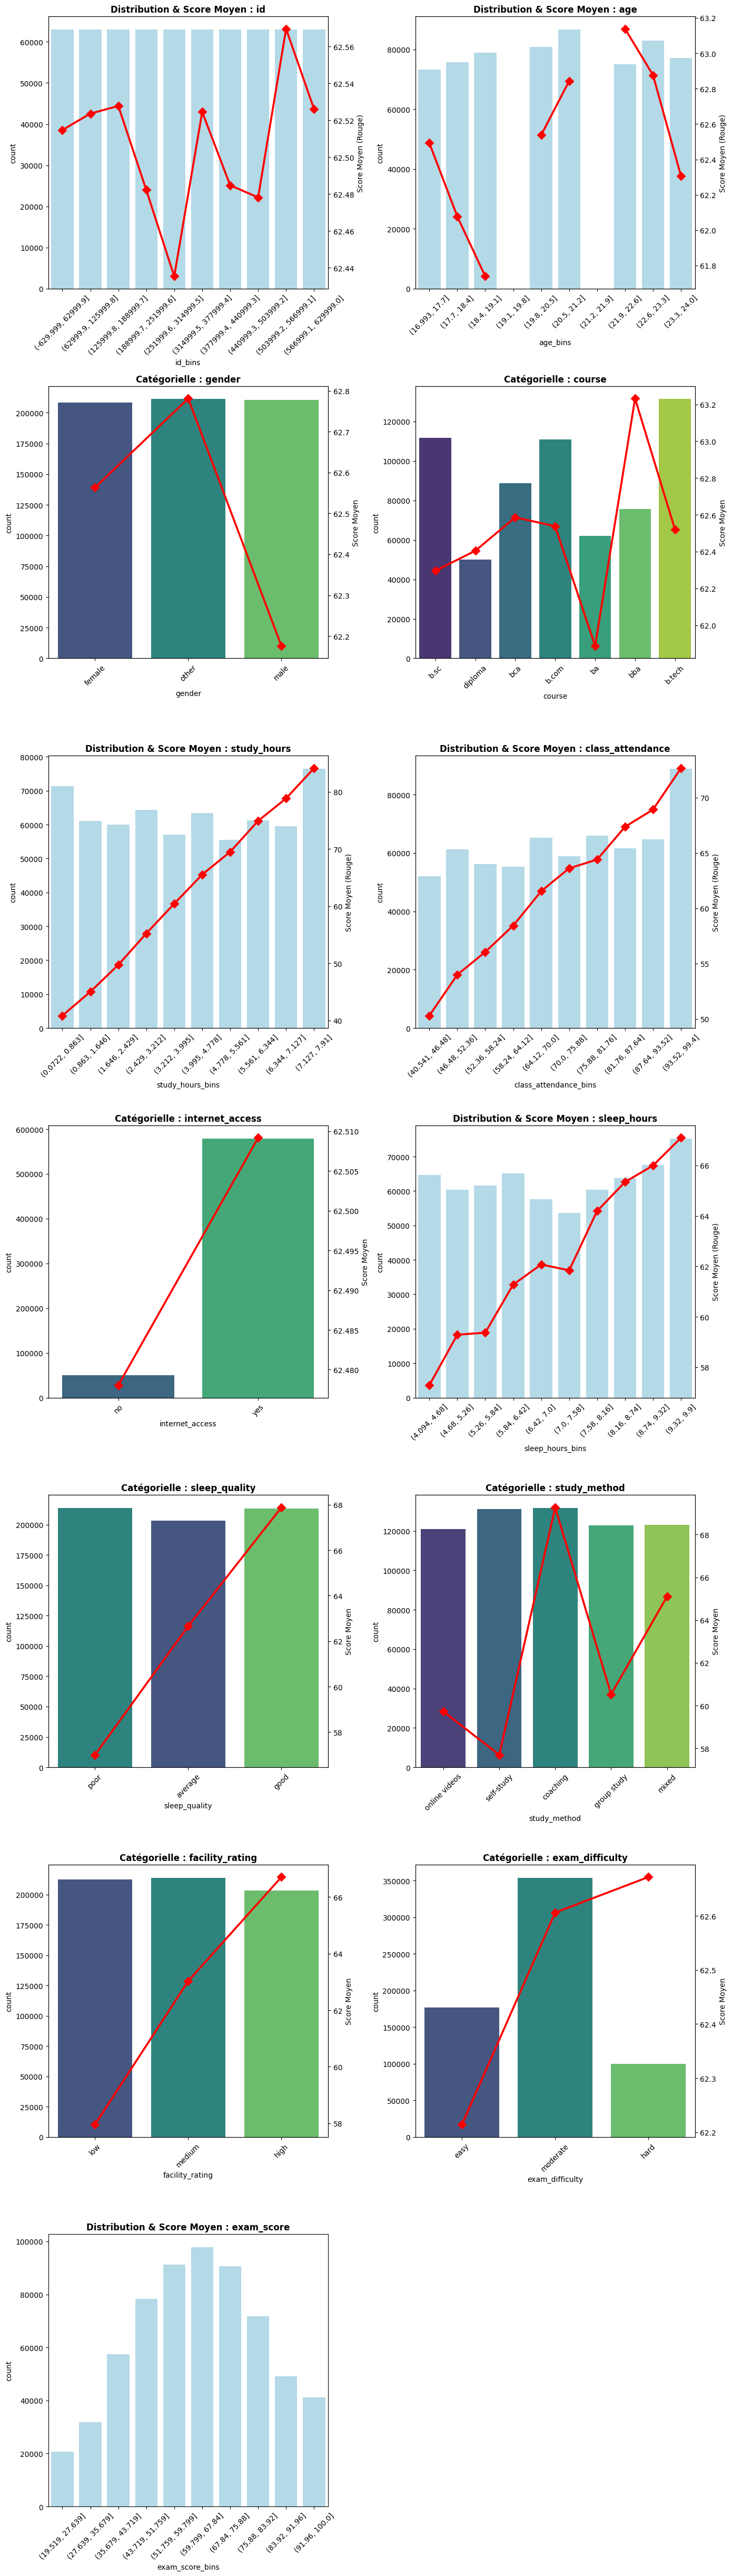

In [7]:
# Dictionnary definition
ordinal_orders = {
    'sleep_quality': ['poor', 'average', 'good'],
    'facility_rating': ['low', 'medium', 'high'],
    'exam_difficulty': ['easy', 'moderate', 'hard']
}
# ordinal_orders={}

# Grid configuration
num_col = train_df.shape[1]
num_rows=math.ceil(num_col/2)
side_length=7
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(side_length * 2, side_length * num_rows))
axes = axes.flatten() # Pour itérer facilement sur les axes

for i, col in enumerate(train_df.columns):
    ax = axes[i]
    
    if train_df[col].dtype in ['object', 'category']:
        # --- categorical variables ---
        current_order = ordinal_orders.get(col, train_df[col].unique())
        
        # Distribution 
        sns.countplot(data=train_df, x=col, ax=ax, order=current_order, 
                      hue=col, palette='viridis', legend=False)
        ax.set_title(f"Catégorielle : {col}", fontweight='bold')
        ax.tick_params(axis='x', rotation=45)
        
        # To add exam score
        if col != 'exam_score':
            ax2 = ax.twinx()
            sns.pointplot(data=train_df, x=col, y='exam_score',order=current_order,
                          ax=ax2, color='red', markers='D',errorbar=None)
            ax2.set_ylabel('Score Moyen')

    else:
        # ---Step A: Create 10 intervals (bins) for the numeric variable ---
        # We use pd.cut to divide the column into 10 equal groups
        train_df[f'{col}_bins'] = pd.cut(train_df[col], bins=10)
        
        # --- Step B: Plot the histogram (Distribution) ---
        sns.countplot(data=train_df, x=f'{col}_bins', ax=ax, color='skyblue', alpha=0.7)
        ax.set_title(f"Distribution & Score Moyen : {col}", fontweight='bold')
        ax.tick_params(axis='x', rotation=45)
        
        # --- Step C: Plot the Average Score per interval ---
        if col != 'exam_score':
            ax2 = ax.twinx()
            # We calculate the average score per bin
            sns.pointplot(data=train_df, x=f'{col}_bins', y='exam_score', 
                          ax=ax2, color='red', markers='D', errorbar=None)
            ax2.set_ylabel('Score Moyen (Rouge)')
    
        # Cleaning the temporary bin column
        train_df.drop(columns=[f'{col}_bins'], inplace=True)

# Cleanup: remove empty axes if the number of columns is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Analysis of a specific correlation between 2 input

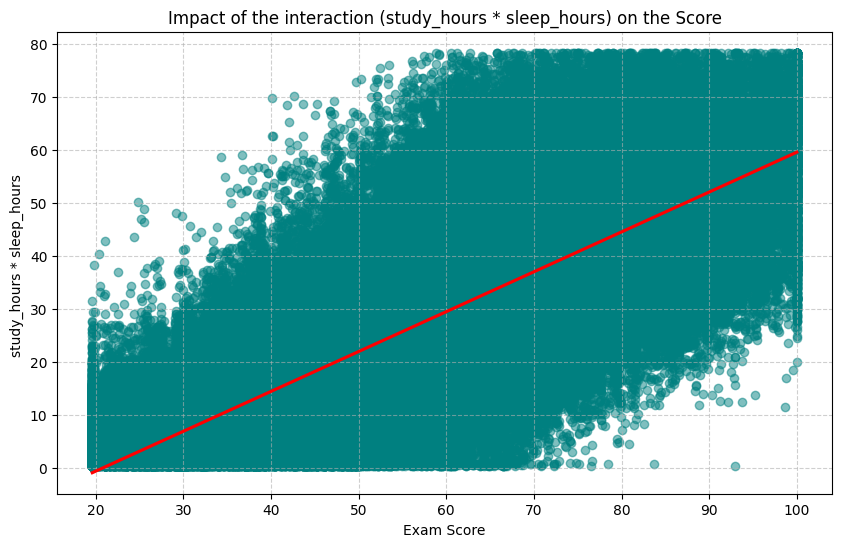

In [8]:

poor_sleep_df = train_df[train_df['sleep_quality'].str.lower() == 'poor'].copy()

poor_sleep_df['interaction_age_hours']=poor_sleep_df['study_hours']*poor_sleep_df['sleep_hours']

plt.figure(figsize=(10, 6))
sns.regplot(data=poor_sleep_df, x='exam_score', y='interaction_age_hours', ci=None,
            scatter_kws={'alpha':0.5, 'color':'teal'}, 
            line_kws={'color':'red'})

plt.title('Impact of the interaction (study_hours * sleep_hours) on the Score')
plt.xlabel('Exam Score')
plt.ylabel('study_hours * sleep_hours ')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# **Exploration of data dependencies**

<class 'pandas.core.indexes.base.Index'>


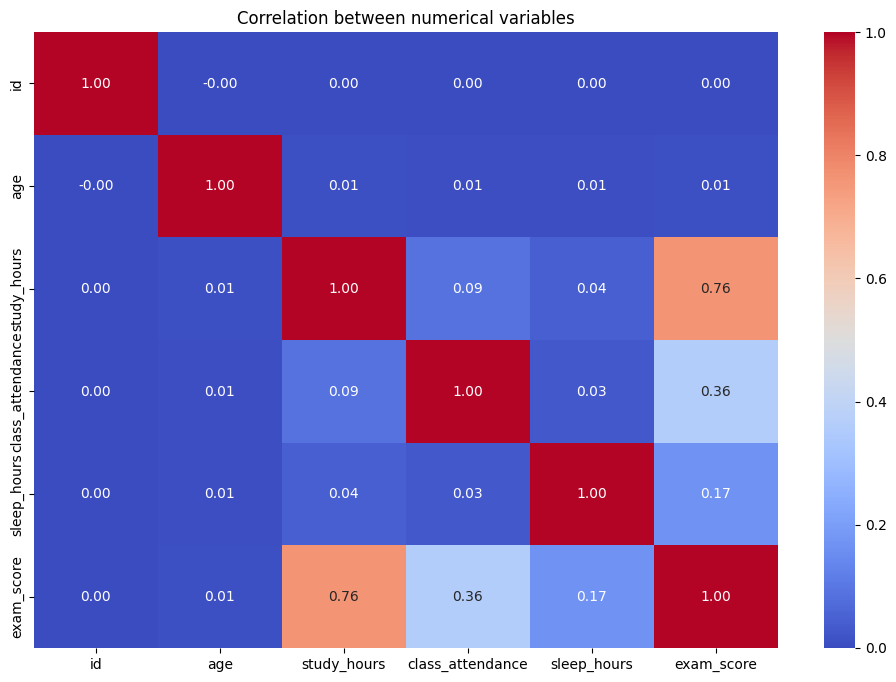

In [9]:
print(type(numeric_cols))

# Calculation of the correlation Matrix
corr_matrix = train_df[numeric_cols].corr()

# Graphic display
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation between numerical variables")
plt.show()

In [10]:
corr_with_target = corr_matrix['exam_score'].sort_values(ascending=False)
print(corr_with_target)

exam_score          1.000000
study_hours         0.762267
class_attendance    0.360954
sleep_hours         0.167410
age                 0.010472
id                  0.000372
Name: exam_score, dtype: float64


In [11]:
train_df_p=train_df.copy()

for col in cat_cols:
    le = LabelEncoder()
    train_df_p[col+'_enc'] = le.fit_transform(train_df_p[col])

# Recalcul de la corrélation avec la cible
encoded_cols = [c+'_enc' for c in cat_cols]
corr_cat = train_df_p[encoded_cols + ['exam_score']].corr()['exam_score'].sort_values(ascending=False)
print(corr_cat)

exam_score             1.000000
exam_difficulty_enc    0.008337
gender_enc             0.004748
course_enc             0.003874
internet_access_enc    0.000447
facility_rating_enc   -0.076605
sleep_quality_enc     -0.124749
study_method_enc      -0.183431
Name: exam_score, dtype: float64


In [12]:
# Pearson correlation
corr = train_df_p['sleep_hours'].corr(train_df_p['sleep_quality_enc'])
print(f"Corrélation entre sleep_hours et sleep_quality : {corr:.2f}")

Corrélation entre sleep_hours et sleep_quality : -0.02


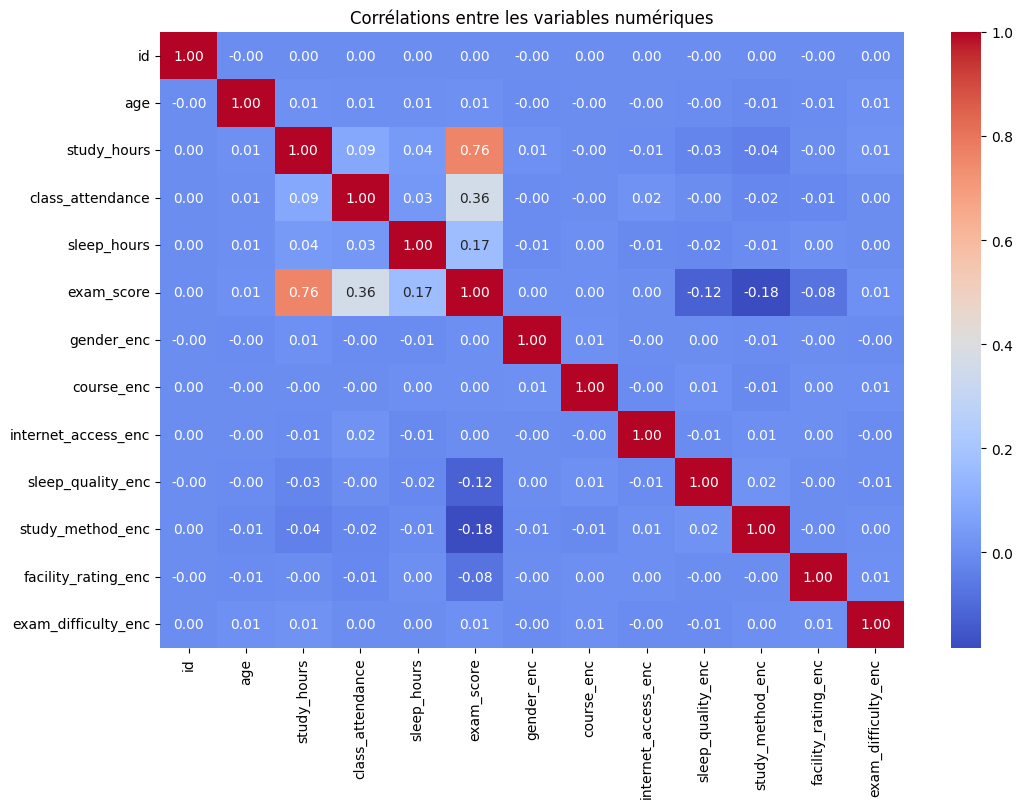

In [13]:
# Calculation of the correlation Matrix
corr_matrix = train_df_p[list(numeric_cols)+encoded_cols].corr()

# Graphic display
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Corrélations entre les variables numériques")
plt.show()

## Original Data

In [14]:
print(orig_df.head())

   student_id  age  gender   course  study_hours  class_attendance  \
0           1   17    male  diploma         2.78              92.9   
1           2   23   other      bca         3.37              64.8   
2           3   22    male     b.sc         7.88              76.8   
3           4   20   other  diploma         0.67              48.4   
4           5   20  female  diploma         0.89              71.6   

  internet_access  sleep_hours sleep_quality   study_method facility_rating  \
0             yes          7.4          poor       coaching             low   
1             yes          4.6       average  online videos          medium   
2             yes          8.5          poor       coaching            high   
3             yes          5.8       average  online videos             low   
4             yes          9.8          poor       coaching             low   

  exam_difficulty  exam_score  
0            hard        58.9  
1        moderate        54.8  
2       

# **Implementation of the Model**

In [15]:
# =========================
# Featuring engineering
# =========================

target = 'exam_score'
id_col = 'id'

# Columns to delete
col_to_del=['age','gender','exam_difficulty','course','internet_access',
            ]
orig_col_to_del=['age','gender','exam_difficulty','course','internet_access',
                 'study_sleepq_sq','manual_formula','feature_formula']


# Mapping definition for categorical variables

ordinal_mapping = {
        'sleep_quality': {'good': 5, 'average': 0, 'poor': -5},
        'facility_rating': {'high': 4, 'medium': 0, 'low': -4},
        'study_method': {'coaching': 10,'mixed': 5,'group study': 2,
            'online videos': 1,
            'self-study': 0
            },
        'exam_difficulty': {'easy': 1, 'moderate': 2, 'hard': 3}

    }

# Mapping application
for col, mapping in ordinal_mapping.items():
    train_df[col] = train_df[col].map(mapping)
    test_df[col] = test_df[col].map(mapping)
    orig_df[col] = orig_df[col].map(mapping)

# List of dataframes for grouped application
dfs = [train_df, test_df, orig_df]

# Featuring exploration

for df in dfs:
    df['study_sleepq'] = df['study_hours'] * df['sleep_quality']
    df['study_sleepq_sq'] = df['study_sleepq']**2
    df['study_plus_attendance']=df['study_hours']+df['class_attendance']

    df['feature_formula'] = (
        5.9051154511950499 * df['study_hours'] + 
        0.34540967058057986 * df['class_attendance'] + 
        1.423461171860262 * df['sleep_hours'] + 4.7819
    )
    
    df['manual_formula'] = (
        6.0 * df['study_hours'] +
        0.35 * df['class_attendance'] +
        1.5 * df['sleep_hours'] +
        df['sleep_quality'] +
        df['study_method'] + 
        df['facility_rating']
    )
    
    # 3. Transformations Study Hours
    df['log_study_hours'] = np.log1p(df['study_hours']) 
    df['study_hours_sq'] = df['study_hours']**2
    df['study_hours_sin'] = np.sin(2 * np.pi * df['study_hours'] / 12)
    
    # 4. Transformations Class Attendance
    df['log_class_attendance'] = np.log1p(df['class_attendance'])
    df['class_attendance_sq'] = df['class_attendance']**2


# Specific NN recording variable
Xnn=train_df.drop(columns=[target, id_col])
ynn = train_df[target]
Xnn_test=test_df.drop(columns=[id_col])


# Deleting columns
X = train_df.drop(columns=[target, id_col])
Xorig = orig_df.drop(columns=[target, 'student_id'])


y = (train_df[target])
yorig = (orig_df[target])

X_test = test_df.drop(columns=[id_col])


# Encoding of last categorical varaible

categorical_cols = X.select_dtypes(include=['object']).columns

encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    Xorig[col]= le.fit_transform(Xorig[col])
    X_test[col] = le.transform(X_test[col])
    encoders[col] = le

# =============================
# Split train / validation data
# ==============================

# Current model
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Original model
Xorig_train, Xorig_val, yorig_train, yorig_val = train_test_split(
    Xorig, yorig, test_size=0.02, random_state=42
)

# ******** Columns management

# Intermediate model
X_train_i=X_train.copy().drop(columns=orig_col_to_del)
X_val_i=X_val.copy().drop(columns=orig_col_to_del)
X_test_i=X_test.copy().drop(columns=orig_col_to_del)

# Manual selection of inlet
X = X.drop(columns=col_to_del)
X_train = X_train.drop(columns=col_to_del)
X_val = X_val.drop(columns=col_to_del)
# Xorig = Xorig.drop(columns=col_to_del)
X_test = X_test.drop(columns=col_to_del)


# Specific adjustment
Xorig = Xorig.drop(columns=orig_col_to_del)
Xorig_train = Xorig_train.drop(columns=orig_col_to_del)
Xorig_val = Xorig_val.drop(columns=orig_col_to_del)


# ====================================
# Model definition: XGBoost, CatBoost
# ====================================

# XGBoost version of Current model ref

model = xgb.XGBRegressor(
    n_estimators=10000, 
    learning_rate=0.05, 
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,     
    reg_lambda=5,    
    early_stopping_rounds=50, 
    objective='reg:squarederror',
    random_state=42
)

# Optionnal CatBoost Version for current model
model_cat = CatBoostRegressor(
    iterations=10000,
    learning_rate=0.05,
    depth=4,
    subsample=0.8,
    rsm=0.8,
    l2_leaf_reg=5,
    loss_function='RMSE',
    eval_metric='RMSE',
    od_type='Iter',
    od_wait=50,
    random_seed=42,
    verbose=100
)

# XGB version of the original model
model_orig = xgb.XGBRegressor(
    n_estimators=10000, # On met un chiffre haut
    learning_rate=0.01, 
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,     # L1 beaucoup plus bas
    reg_lambda=5,    # Ajout de L2
    early_stopping_rounds=50, # S'arrête si pas de progrès pendant 50 tours
    objective='reg:squarederror',
    random_state=42
)

# Original model fitting
model_orig.fit(Xorig_train, yorig_train,
         eval_set=[(Xorig_val, yorig_val)], 
    verbose=100)                

# Validation of the orginal model
yorig_val_pred = model_orig.predict(Xorig_val)
rmse_orig = mean_squared_error((yorig_val), (yorig_val_pred)) ** 0.5
print("RMSE originale validation :", rmse_orig)


# New column added for current model from the original model result
X_train['score_orig']=model_orig.predict(X_train_i)
X_test['score_orig']=model_orig.predict(X_test_i)
X_val['score_orig']=model_orig.predict(X_val_i)


# Training phase for the current model

# XGBoost Version
model.fit(X_train, y_train,
         eval_set=[(X_val, y_val)], 
    verbose=100)                 

# CatBoost Version
# model_cat.fit(
#     X_train, y_train,
#     eval_set=(X_val, y_val),
#     use_best_model=True
# )


# ************** Auto-Gluon application ********************************
# ____________________________________________________________________
# Auto-Gluon results gives a hybrid model using XGBoost and CatBoost
# But the final score reached by Auto-Gluon is not the best.
# _____________________________________________________________________

# X_train_glu=X_train.copy()
# X_train_glu['exam_score']=y_train

# X_val_glu=X_val.copy()
# X_val_glu['exam_score']=y_val

# predictor = TabularPredictor(label="exam_score",
#                             problem_type='regression',
#     eval_metric='root_mean_squared_error').fit(train_data=X_train_glu)

# y_val_pred = predictor.predict(X_val_glu)

# **************************************************************************

# =========================
# Model validation
# =========================

# XGBoost Version
y_val_pred = model.predict(X_val)

#  CatBoost Version
# y_val_pred = model_cat.predict(X_val)


# RMSE evaluation
rmse = mean_squared_error((y_val), (y_val_pred)) ** 0.5

print("RMSE validation :", rmse)

[0]	validation_0-rmse:18.78019
[100]	validation_0-rmse:12.64651
[200]	validation_0-rmse:10.83035
[300]	validation_0-rmse:10.16441
[400]	validation_0-rmse:9.90083
[500]	validation_0-rmse:9.80385
[600]	validation_0-rmse:9.77473
[700]	validation_0-rmse:9.76546
[794]	validation_0-rmse:9.76474
RMSE originale validation : 9.762665530016745
[0]	validation_0-rmse:18.13184
[100]	validation_0-rmse:8.82897
[200]	validation_0-rmse:8.80218
[300]	validation_0-rmse:8.78620
[400]	validation_0-rmse:8.77295
[500]	validation_0-rmse:8.76270
[600]	validation_0-rmse:8.75380
[700]	validation_0-rmse:8.74670
[800]	validation_0-rmse:8.74052
[900]	validation_0-rmse:8.73474
[1000]	validation_0-rmse:8.73016
[1100]	validation_0-rmse:8.72575
[1200]	validation_0-rmse:8.72201
[1300]	validation_0-rmse:8.71840
[1400]	validation_0-rmse:8.71508
[1500]	validation_0-rmse:8.71218
[1600]	validation_0-rmse:8.70959
[1700]	validation_0-rmse:8.70746
[1800]	validation_0-rmse:8.70534
[1900]	validation_0-rmse:8.70323
[2000]	validati

# **Analysis of the resulting models**

## Results from the orignal model

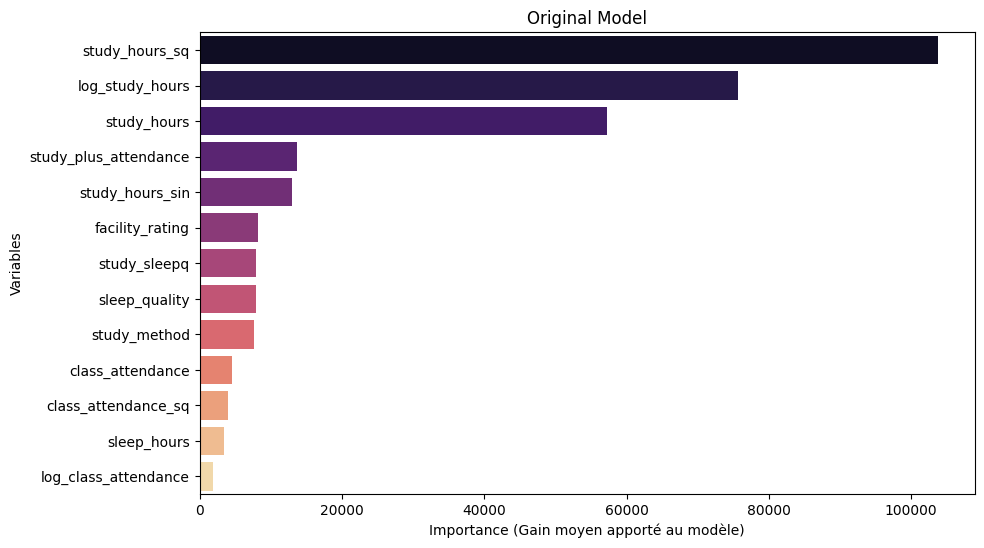

In [16]:
# DataFrame Creation to identify important keys
feature_important_orig = model_orig.get_booster().get_score(importance_type='gain')
keys_orig = list(feature_important_orig.keys())
values_orig = list(feature_important_orig.values())

df_importance_orig = pd.DataFrame(data={'Feature': keys_orig, 'Importance': values_orig})
df_importance_orig = df_importance_orig.sort_values(by='Importance', ascending=False)

# Graphic display
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_importance_orig, palette='magma', hue='Feature', legend=False)
plt.title('Original Model')
plt.xlabel('Importance (Gain moyen apporté au modèle)')
plt.ylabel('Variables')
plt.show()

## Results from the Current model

### XGBoost Version

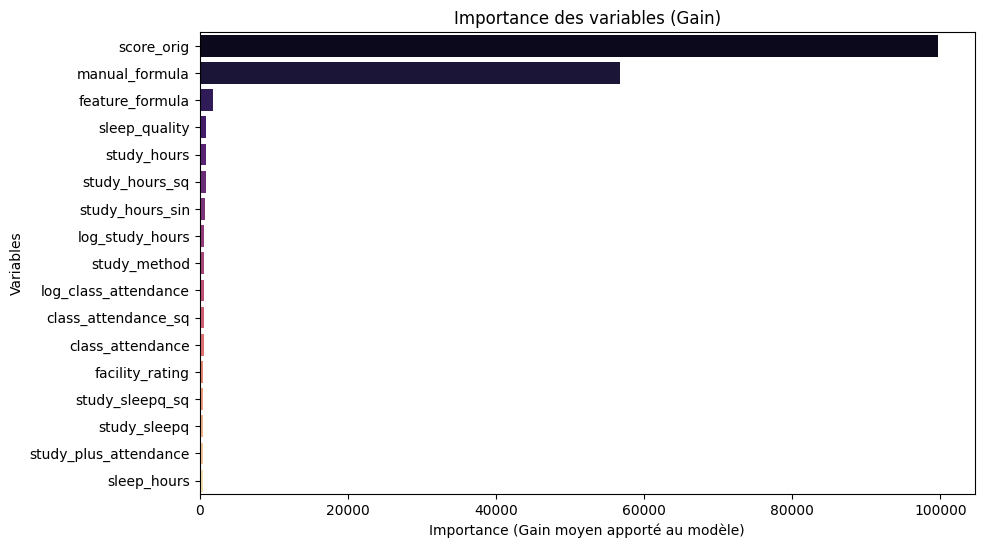

In [17]:
# DataFrame Creation to identify important keys
feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

df_importance = pd.DataFrame(data={'Feature': keys, 'Importance': values})
df_importance = df_importance.sort_values(by='Importance', ascending=False)

# Graphic display
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_importance, palette='magma', hue='Feature', legend=False)
plt.title('Importance des variables (Gain)')
plt.xlabel('Importance (Gain moyen apporté au modèle)')
plt.ylabel('Variables')
plt.show()

### CatBoost Version

In [18]:
# # Pool creation
# train_pool = Pool(
#     data=X_train,
#     label=y_train,
# )

## Identify important keys
# importances = model_cat.get_feature_importance(
#     data=train_pool,   # <-- ici on passe le Pool
#     type="LossFunctionChange"
# )

# # DataFrame to graphic display
# feature_names = model_cat.feature_names_
# df_importance = pd.DataFrame({
#     "Feature": feature_names,
#     "Importance": importances
# }).sort_values(by="Importance", ascending=False)

# # Graphic display
# plt.figure(figsize=(10, 6))
# sns.barplot(
#     data=df_importance,
#     x="Importance",
#     y="Feature",
#     palette="magma"
# )

# plt.title("Importance des variables (Loss Function Change)")
# plt.xlabel("Importance (réduction moyenne de la loss)")
# plt.ylabel("Variables")
# plt.tight_layout()
# plt.show()

In [19]:
# # 1. Calcul de l'erreur (le résidu) sur le train
# train_preds = model.predict(X_train)
# residuals = y_train - train_preds

# # 2. Entraîner un second modèle pour prédire le résidu
# error_model = xgb.XGBRegressor(n_estimators=100, max_depth=3)
# error_model.fit(X_train, residuals)

# # 3. Prédiction finale = Modèle initial + Erreur prédite
# final_val_preds = model.predict(X_val) + error_model.predict(X_val)
# rmse = mean_squared_error(y_val, final_val_preds) ** 0.5
# print("RMSE validation :", rmse)

# **Hybrid model: Linear + NN Model (residuals)**

# Categoricals variables encoding

In [20]:
# Columns to remove for the neural network
col_to_del_nn = ['age', 'gender', 'exam_difficulty', 'course', 'internet_access']

Xnn = Xnn.drop(columns=col_to_del_nn)
Xnn_test = Xnn_test.drop(columns=col_to_del_nn)

# Encoding of NN input
categorical_cols_nn = Xnn.select_dtypes(include=['object']).columns
numerical_cols_nn = Xnn.select_dtypes(exclude=['object']).columns.tolist()

# Create the transformer
# sparse_output=False is important for neural networks (they require dense matrices)
# handle_unknown='ignore' prevents errors if the test set contains unseen categories
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_nn),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols_nn)
    ])

#  Fit on the training set and transform it
Xnn_transformed = preprocessor.fit_transform(Xnn)

# Transform the test set (without re-fitting)
Xnn_test_transformed = preprocessor.fit_transform(Xnn_test)

# Split into training and validation sets
Xxgb_train, Xxgb_val, yxgb_train, yxgb_val = train_test_split(
    Xnn_transformed, ynn, test_size=0.2, random_state=42
)


## **Linear Model**

In [21]:
# Initialization
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_predictions = np.zeros(len(Xnn_transformed))
Xlin = Xnn_transformed
ylin = ynn

# Cross-validation loop
for train_index, val_index in kf.split(Xlin):
    # Data split
    Xnn_train, Xnn_val = Xlin[train_index], Xlin[val_index]
    ynn_train, ynn_val = ylin[train_index], ylin[val_index]
    
    # Train the linear model
    model_lin = LinearRegression()
    model_lin.fit(Xnn_train, ynn_train)
    
    # Prediction on the validation fold (OOF)
    oof_predictions[val_index] = model_lin.predict(Xnn_val)

# Add predictions and compute residuals in the DataFrame
Xnn['linear_preds'] = oof_predictions
Xnn['residuals'] = ynn - Xnn['linear_preds']

rmse_linear = mean_squared_error(ynn, Xnn['linear_preds']) ** 0.5

print(f"RMSE Linear : {rmse_linear:.5f}")


RMSE Linear : 8.89176


## **Neural Network Model (residuals)** 

In [22]:
Xnn_train, Xnn_val, ynn_train, ynn_val = train_test_split(
    Xnn_transformed, ynn, test_size=0.2, random_state=42
)

# residuals = current value - predict value (linear model)
residus_train = ynn_train-model_lin.predict(Xnn_train)

def build_residual_model(input_shape):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        layers.Dropout(0.2), 
        layers.Dense(32, activation='relu'),
        layers.Dense(1) 
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Training
res_model = build_residual_model(Xnn_train.shape[1])
res_model.fit(Xnn_train, residus_train, epochs=3, 
              batch_size=32, validation_split=0.2)

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-02-03 08:41:57.838021: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


12600/12600 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 79.0385 - mae: 7.1040 - val_loss: 79.1993 - val_mae: 7.1071
Epoch 2/3
12600/12600 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 78.7145 - mae: 7.0902 - val_loss: 79.1178 - val_mae: 7.1088
Epoch 3/3
12600/12600 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 78.8982 - mae: 7.1027 - val_loss: 79.0897 - val_mae: 7.1024


In [23]:
# Prediction of the error by the neural network
predicted_residus = res_model.predict(Xnn_val).flatten()

# Correction
ynn_final_pred = model_lin.predict(Xnn_val) + predicted_residus

rmse = mean_squared_error(ynn_val, ynn_final_pred) ** 0.5
print("RMSE validation :", rmse)

3938/3938 ━━━━━━━━━━━━━━━━━━━━ 3s 736us/step
RMSE validation : 8.864833411365913


# **Results feed back analysis**

**Specific analysis for low study hours group : exam score fonction of study method** 

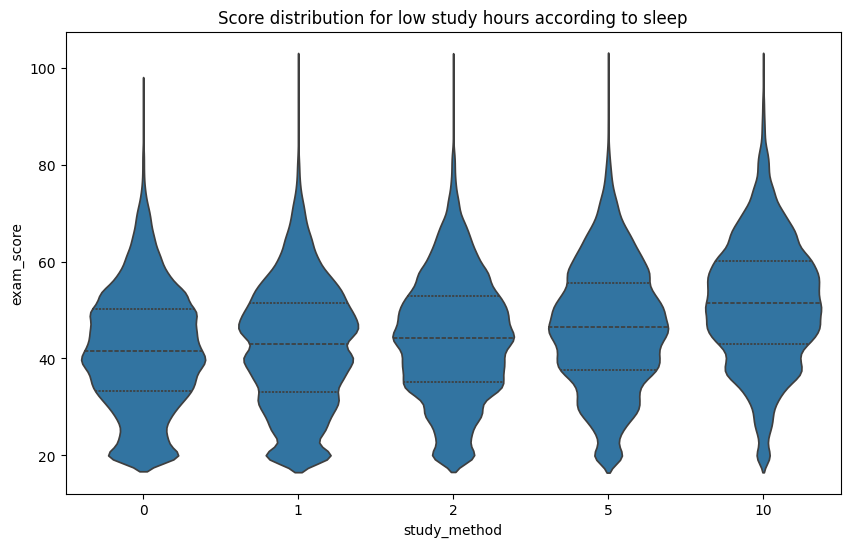

In [24]:
# Low study hours selection
high_risk_df = train_df[train_df['study_hours'] < 2.5]

# Graphic Display
plt.figure(figsize=(10, 6))
sns.violinplot(data=high_risk_df, x='study_method', y='exam_score', inner="quart")
plt.title('Score distribution for low study hours according to sleep')
plt.show()

**Study method repartition**

In [25]:
print("Répartition de study_method :")
print(train_df['study_method'].value_counts(dropna=False))

Répartition de study_method :
study_method
10    131697
0     131131
5     123086
2     123009
1     121077
Name: count, dtype: int64


**Analysis of Top 5% error prediction**

In [26]:
errors = np.abs(y_val - y_val_pred)
print(f"Erreur max : {errors.max():.2f}")
print(f"Top 5% des plus grosses erreurs : {np.percentile(errors, 95):.2f}")

Erreur max : 48.57
Top 5% des plus grosses erreurs : 17.08


Graphic Display

In [27]:
# 1. Calcul de l'erreur absolue
val_analysis = X_val.copy()
val_analysis['actual'] = (y_val)
val_analysis['pred'] = (y_val_pred)
val_analysis['abs_error'] = np.abs(val_analysis['actual'] - val_analysis['pred'])

# 2. On isole le top 5% des plus grosses erreurs
threshold = val_analysis['abs_error'].quantile(0.95)
top_errors = val_analysis[val_analysis['abs_error'] > threshold]

print(f"Seuil d'erreur critique : {threshold:.2f}")
print(f"Nombre de cas critiques : {len(top_errors)}")

Seuil d'erreur critique : 17.08
Nombre de cas critiques : 6300


Mean Errors 

In [28]:
print("--- Variable Means (Global vs Top errors) ---")
comparison = pd.DataFrame({
    'Global': val_analysis.mean(),
    'Top Errors': top_errors.mean()
})
print(comparison)

--- Variable Means (Global vs Top errors) ---
                            Global   Top Errors
study_hours               4.015619     3.843617
class_attendance         72.003345    72.569424
sleep_hours               7.073772     7.073889
sleep_quality            -0.005794    -0.111905
study_method              3.653349     3.648571
facility_rating          -0.059429     0.114286
study_sleepq              0.477709    -0.551151
study_sleepq_sq         366.468776   334.409171
study_plus_attendance    76.018964    76.413041
feature_formula          63.434487    62.614492
manual_formula           63.493672    62.722789
log_study_hours           1.468289     1.432540
study_hours_sq           21.697518    20.114702
study_hours_sin           0.338474     0.378872
log_class_attendance      4.259946     4.268329
class_attendance_sq    5487.655543  5565.171165
score_orig               63.301945    62.610580
actual                   62.604022    61.209237
pred                     62.581776    61.8

**Graphic Display : Residuals analysis**

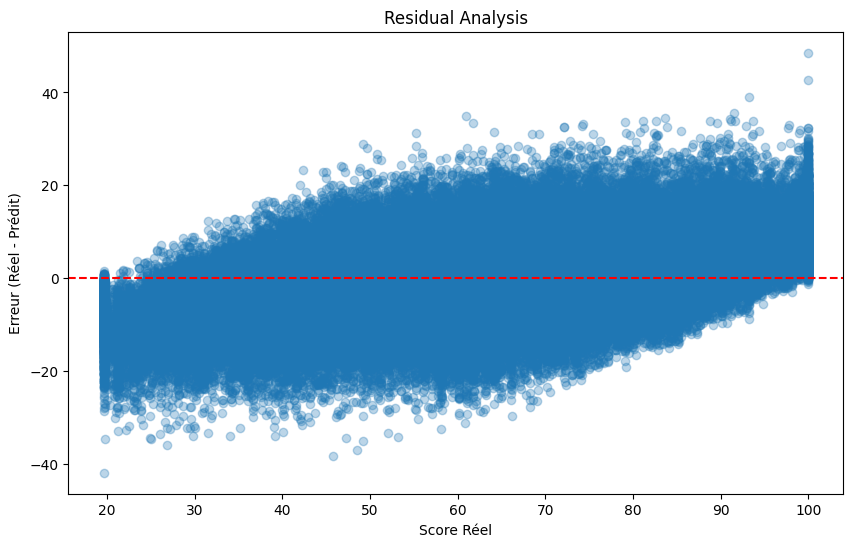

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(val_analysis['actual'], (val_analysis['actual'] - val_analysis['pred']), alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Score Réel')
plt.ylabel('Erreur (Réel - Prédit)')
plt.title('Residual Analysis')
plt.show()

Text(0.5, 1.0, 'Error vs study hours')

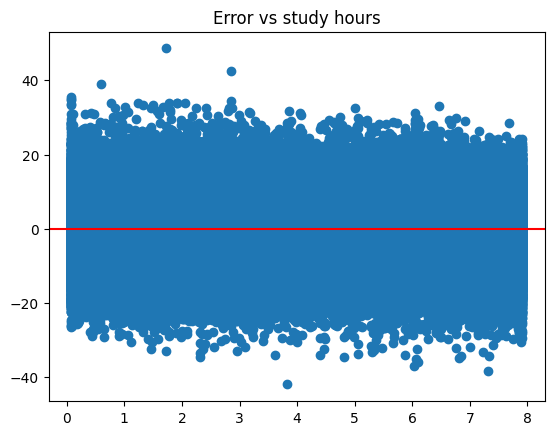

In [30]:
# Error computation
residuals = y_val - y_val_pred

plt.scatter(X_val['study_hours'], residuals)
plt.axhline(0, color='red')
plt.title("Error vs study hours")

# **Final prediction for the competion and submission file creation**

In [31]:
# =========================
# Final prediction
# =========================

test_predictions = model.predict(X_test)

submission = pd.DataFrame({
    'id': test_df[id_col],
    'exam_score': test_predictions
})

print(submission.head())

       id  exam_score
0  630000   70.282257
1  630001   68.935211
2  630002   87.061531
3  630003   55.954960
4  630004   47.214008


In [32]:
submission['exam_score'] = submission['exam_score'].round(1)

# Sauvegarde du fichier
submission.to_csv(
    '/kaggle/working/submission.csv',
    index=False,
    float_format='%.1f'
)
# Vérification
print(submission.head())

       id  exam_score
0  630000   70.300003
1  630001   68.900002
2  630002   87.099998
3  630003   56.000000
4  630004   47.200001


In [33]:
!head /kaggle/working/submission.csv


id,exam_score
630000,70.3
630001,68.9
630002,87.1
630003,56.0
630004,47.2
630005,71.7
630006,74.1
630007,59.4
630008,78.8


In [34]:
print(set(train_df.columns) - set(test_df.columns))

{'exam_score'}


# *Save inlet files of this Notebook*

In [35]:
import shutil

shutil.make_archive(
    "/kaggle/working/input_backup",
    "zip",
    "/kaggle/input"
)

'/kaggle/working/input_backup.zip'